# 09-1 순차 데이터, 순환 신경망

## 순차 데이터
* 시계열(time series): 일정 시간 간격으로 배치된 데이터
  * 매시간 측정한 온도 데이터
* 순차 데이터(sequential data): 시계열 데이터를 포함하여 샘플에 순서가 있는 데이터
  * 텍스트
* 타임 스텝(time step): 모델에서 순차 데이터를 처리하는 각 단계
  * `Hello Deep Learning`
  * 단어 단위면 3 스텝, 글자 단위론 19 스텝


## 순환 신경망
* 순환 구조: 은닉층의 출력이 다시 은닉층의 입력으로 사용되는 구조
* 순환 층: 순환 구조를 가진 층
* 셀: 순환 신경망에서 층이나 뉴런
* 순환 신경망에선 활성화 함수로 하이퍼볼릭 탄젠트(hyperbolic tangent)함수를 많이 사용한다.

## 순환 신경망의 정방향 계산
|순환층|출력층|
|:------:|:------:|
|$Z_1 = XW_{1x} + H_pW_{1h} + b_1$|$Z_2 = XW_{2} + b_2$|
|$H = \tanh(Z_1)$|$A_2 = \text{sigmoid}(Z_2)$|

## 순환 신경망의 역방향 게산
* 출력층
$$
\frac{\partial L}{\partial W_2} = H^T(-(Y-A_2)) \\
\frac{\partial L}{\partial b_2} = 1^T(-(Y-A_2))
$$

* 순환층
$$
\frac{\partial L}{\partial Z_1} = -(Y-A_2)W_2^T \odot (1 - H^2) \\
\frac{\partial Z_1}{\partial W_{1h}} = H_p + H_{pp}W_{1h}\odot(1-H_p^2) + H_{ppp}W_{1h}\odot(1-H_p^2)\odot W_{1h}\odot(1-H_{pp}^2) + \dots \\
\frac{\partial Z_1}{\partial W_{1x}} = X + XW_{1h}\odot(1-H_p^2) + XW_{1h}\odot(1-H_p^2)\odot W_{1h}\odot(1-H_{pp}^2) + \dots \\
\frac{\partial Z_1}{\partial b_1} = 1 + W_{1h}\odot(1-H_p^2) + W_{1h}\odot(1-H_p^2)\odot W_{1h}\odot(1-H_{pp}^2) + \dots

$$

# 09-2 순환 신경망 만들기


In [1]:
import tensorflow as tf

## 훈련 세트, 검증 세트

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

In [3]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [4]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


* BoW(Bag of Word), 어휘 사전
* 많이 등장하는 영단어 20개를 건너뛰고 100개 단어만 선택했기 대문에 사전에 없는 영단어가 많다.

In [5]:
# 훈련 세트에서 2 제외하기
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [6]:
# 어휘 사전 내려받기
word_to_index = imdb.get_word_index()
word_to_index['movie']

17

In [7]:
# 훈련 세트의 정수 영단어로 변환
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w-3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [8]:
# 훈련 샘플 길이 확인
print(len(x_train_all[0]), len(x_train_all[1]))
# 길이가 다르면 훈련 시키기 힘들다

59 32


In [9]:
# 훈련 세트의 타깃 데이터 확인 - 긍정(1) 부정(0)
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [10]:
# 검증 세트 준비
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

## 샘플 길이 맞추기

In [11]:
# 텐서플로로 샘플 길이 맞추기
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)


In [12]:
# 크기 확인
print(x_train_seq.shape, x_val_seq.shape)

print(x_train_seq[0])

(20000, 100) (5000, 100)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


## 샘프 원-핫 인코딩하기

In [13]:
# 텐서플로로 원-핫 인코딩
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [14]:
print(x_train_onehot.shape)

(20000, 100, 100)


In [15]:
print(x_train_onehot.nbytes)

800000000


## 순환 신경망 클래스 구현
6장에서 구현한 MiniBatchNetwork 클래스 기반

In [16]:
class RecurrentNetwork:
    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1) -> None:
        self.n_cells = n_cells
        self.batch_size = batch_size
        self.w1h = None
        self.w1x = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.h = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate

    def forpass(self, x):
        # 은닉 상태 초기화
        self.h = [np.zeros((x.shape[0], self.n_cells))]
        # 배치 차원, 타임 스텝 차원 교환
        seq = np.swapaxes(x, 0, 1)
        # 순환층의 선형식 계산
        for x in seq:
            z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
            h = np.tanh(z1)
            self.h.append(h)
            z2 = np.dot(h, self.w2) + self.b2
        return z2

    def backprop(self, x, err):
        m = len(x)

        # 출력층의 가중치와 절편에 대한 그레이디언트 계산
        w2_grad = np.dot(self.h[-1].T, err) / m
        b2_grad = np.sum(err) / m

        # 배치 차원, 타임 스텝 차원 교환
        seq = np.swapaxes(x, 0, 1)

        w1h_grad = w1x_grad = b1_grad = 0
        # 셀 직전까지 gradient 계산
        err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1] ** 2)
        # 모든 타임 스텝을 거슬러 가면서 gradient 전파
        for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            # 이전 타임 스텝의 셀 직전까지 gradient 계산
            err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h**2)

        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m

        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad

    def sigmoid(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a

    def init_weights(self, n_features, n_classes):
        orth_init = tf.initializers.Orthogonal()
        glorot_init = tf.initializers.GlorotUniform()

        self.w1h = orth_init((self.n_cells, self.n_cells)).numpy()
        self.w1x = glorot_init((n_features, self.n_cells)).numpy()
        self.b1 = np.zeros(self.n_cells)
        self.w2 = glorot_init((self.n_cells, n_classes)).numpy()
        self.b2 = np.zeros(n_classes)

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42)
        self.init_weights(x.shape[2], y.shape[1])

        for i in range(epochs):
            print('에포크', i, end=' ')
            # generator 함수에서 반환한 미니 배치를 순환한다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                a = self.training(x_batch, y_batch)

                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
                batch_losses.append(loss)

            print()
            self.losses.append(np.mean(batch_losses))

            self.update_val_loss(x_val, y_val)

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i+1)

            yield x[start:end], y[start:end]

    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = self.sigmoid(z)
        err = -(y - a)

        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)

        self.w1h -= self.lr * w1h_grad
        self.w1x -= self.lr * w1x_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def predict(self, x):
        z = self.forpass(x)
        return z > 0

    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.sigmoid(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append(val_loss)

## 순환 신경망 모델 훈련

In [ ]:
# 순환 신경망 모델 훈련
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)

rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

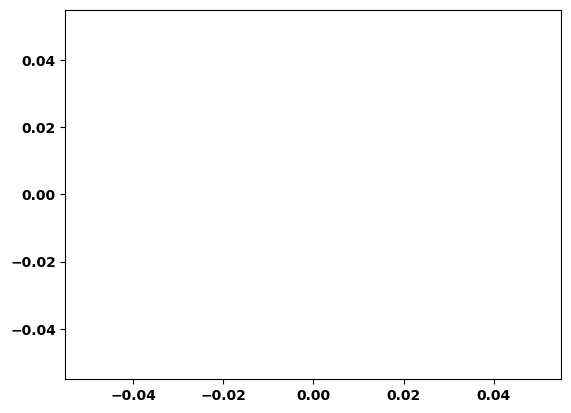

In [18]:
import matplotlib.pyplot as plt

plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show()

In [19]:
rn.score(x_val_onehot, y_val)

0.564

# 09-3 텐서플로로 순환 시경망 만들기

## SimpleRNN 클래스로 순환 신경망 만들기

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [21]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(100, 100)))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32,
                    validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 45s 68ms/step - loss: 0.7068 - accuracy: 0.5044 - val_loss: 0.6969 - val_accuracy: 0.5204
Epoch 2/20
625/625 [==============================] - 47s 75ms/step - loss: 0.6965 - accuracy: 0.5177 - val_loss: 0.6914 - val_accuracy: 0.5274
Epoch 3/20
625/625 [==============================] - 43s 69ms/step - loss: 0.6910 - accuracy: 0.5314 - val_loss: 0.6866 - val_accuracy: 0.5442
Epoch 4/20
625/625 [==============================] - 43s 68ms/step - loss: 0.6834 - accuracy: 0.5556 - val_loss: 0.6742 - val_accuracy: 0.5812
Epoch 5/20
625/625 [==============================] - 46s 74ms/step - loss: 0.6715 - accuracy: 0.5785 - val_loss: 0.6763 - val_accuracy: 0.5644
Epoch 6/20
625/625 [==============================] - 39s 63ms/step - loss: 0.6466 - accuracy: 0.6263 - val_loss: 0.6272 - val_accuracy: 0.6494
Epoch 7/20
625/625 [==============================] - 42s 68ms/step - loss: 0.6271 - accuracy: 0.6490 - val_loss: 0.6163 - val_accuracy:

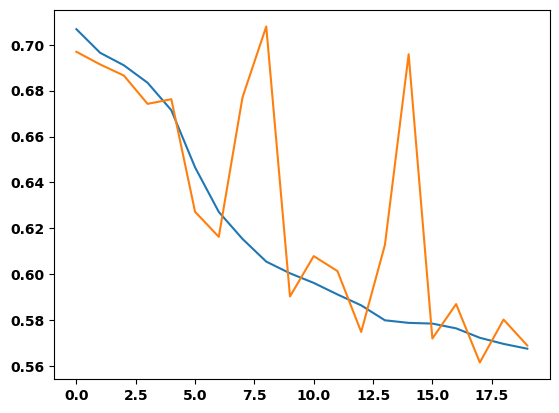

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


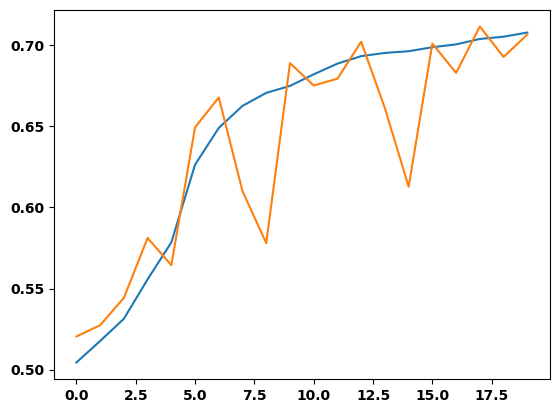

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()


In [25]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)

In [26]:
print(accuracy)

0.70660001039505


## 임베딩층으로 모델 성능 높이기
* 원-핫 인코딩을 사용하면 데이터 크기와 사용할 수 있는 영단어 수가 제한되는 문제가 있고, '단어 사이에는 관련이 전혀 없다'는 가정이 전제되어야 한다.
  * 연관된 두 단어(boy, girl)을 원-핫 인코딩하면 연관없는 두 단어(boy, sun)과 같은 취급이다.


In [27]:
# Embedding class import
from tensorflow.keras.layers import Embedding

In [28]:
# 훈련 데이터
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [29]:
# 샘플 길이 맞추기
maxlen = 100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [30]:
# 모델 만들기
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))

model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 컴파일, 훈련
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32,
                        validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 57s 89ms/step - loss: 0.5930 - accuracy: 0.6598 - val_loss: 0.4870 - val_accuracy: 0.7792
Epoch 2/10
625/625 [==============================] - 63s 101ms/step - loss: 0.4230 - accuracy: 0.8128 - val_loss: 0.4404 - val_accuracy: 0.8028
Epoch 3/10
625/625 [==============================] - 61s 98ms/step - loss: 0.3684 - accuracy: 0.8447 - val_loss: 0.4287 - val_accuracy: 0.8218
Epoch 4/10
625/625 [==============================] - 64s 103ms/step - loss: 0.3254 - accuracy: 0.8684 - val_loss: 0.4158 - val_accuracy: 0.8252
Epoch 5/10
625/625 [==============================] - 64s 103ms/step - loss: 0.2977 - accuracy: 0.8798 - val_loss: 0.4162 - val_accuracy: 0.8222
Epoch 6/10
625/625 [==============================] - 91s 145ms/step - loss: 0.2749 - accuracy: 0.8905 - val_loss: 0.4283 - val_accuracy: 0.8238
Epoch 7/10
625/625 [==============================] - 80s 128ms/step - loss: 0.2504 - accuracy: 0.9036 - val_loss: 0.4485 - val_accu

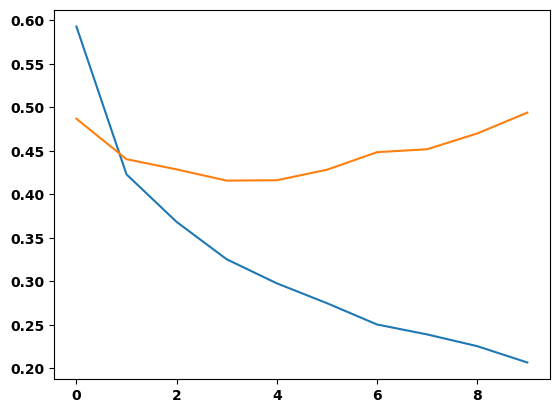

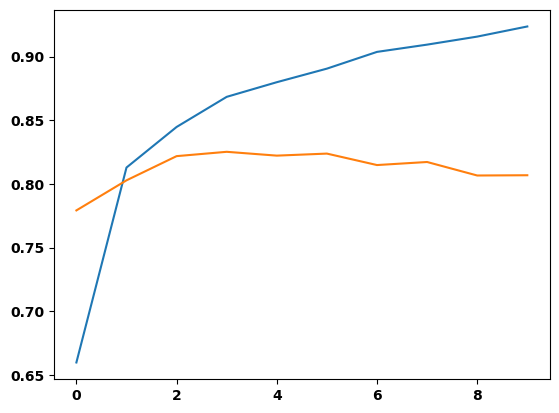

In [32]:
# 그래프 그리기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()


In [33]:
# 검증 세트 정확도 평가
loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8068000078201294


# 09-4 LSTM 순환 신경망 만들기
vanishing gradient 문제를 극복하여 긴 시퀀스를 성공적으로 모델링할 수 있다.

In [34]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential()

model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32,
                         validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 14s 16ms/step - loss: 0.4522 - accuracy: 0.7886 - val_loss: 0.3706 - val_accuracy: 0.8424
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 0.3331 - accuracy: 0.8613 - val_loss: 0.3515 - val_accuracy: 0.8442
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 0.3075 - accuracy: 0.8702 - val_loss: 0.3604 - val_accuracy: 0.8392
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 0.2881 - accuracy: 0.8796 - val_loss: 0.3833 - val_accuracy: 0.8384
Epoch 5/10
625/625 [==============================] - 12s 18ms/step - loss: 0.2756 - accuracy: 0.8864 - val_loss: 0.3724 - val_accuracy: 0.8298
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 0.2624 - accuracy: 0.8888 - val_loss: 0.4139 - val_accuracy: 0.8368
Epoch 7/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2529 - accuracy: 0.8948 - val_loss: 0.3904 - val_accuracy: 0

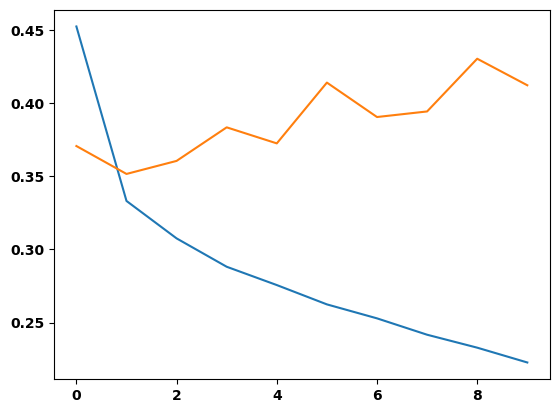

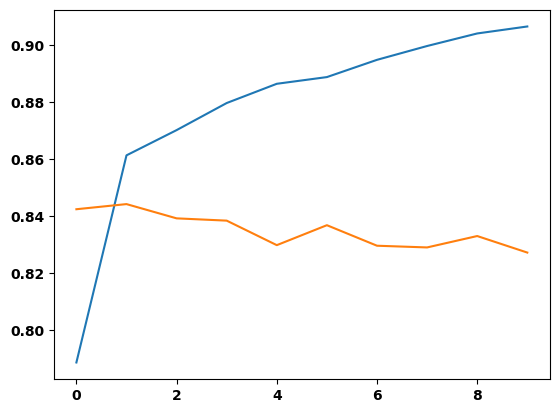

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()


In [37]:
loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8271999955177307
